
# Retail Returns Optimization
## Optimizacion de Devoluciones en Retail

---

### Objetivo
Analizar datos de transacciones para:
1. Identificar patrones y causas raiz de devoluciones
2. Predecir probabilidad de devolucion usando Machine Learning
3. Segmentar clientes segun comportamiento de compra
4. Generar recomendaciones estrategicas para reducir devoluciones

### Pipeline de Datos
Ingesta -> Procesamiento -> Analisis Exploratorio -> Modelado -> Reporting



---
## 1. Introducción y Carga de Datos


In [1]:
# Importar modulos
import warnings
from src.ingesta.loader import DataLoader
from src.procesamiento.transformer import DataTransformer
from src.analisis.eda import ExploratoryAnalysis
from src.modelado.classifier import ReturnClassifier
from src.modelado.clustering import CustomerSegmentation
from src.modelado.evaluation import ModelEvaluator
from src.reportes.visualizations import ExecutiveVisualizer
from src.reportes.strategy import BusinessStrategy

# Configuracion general
warnings.filterwarnings("ignore")
%matplotlib inline

print("Modulos cargados exitosamente.")

Modulos cargados exitosamente.



### 1.1 Ingesta de Datos
Cargamos los datos transaccionales y de estatus desde la fuente (Excel/CSV).


In [2]:
# Cargar datos crudos
loader = DataLoader(data_dir="data/")
df_raw = loader.load_and_merge()

print(f"Dataset cargado: {df_raw.shape[0]:,} registros, {df_raw.shape[1]} columnas")
df_raw.head()

Dataset cargado: 2,223 registros, 9 columnas


,id_orden,fecha,cantidad,prioridad,tipo_cliente,tipo_envio,gerente,estatus,razon
0,AT41255-781,2019-12-21,24,No especificada,Distribuidor,Terrestre,Rene,Entregado,Otro
1,ON41255-889,2019-12-21,47,Alta,Otros,Regular Aereo,Rene,Entregado,Otro
2,YU41254-564,2019-12-20,49,Baja,Otros,Regular Aereo,Ana,Entregado,Otro
3,AT41253-390,2019-12-19,3,Alta,Distribuidor,Regular Aereo,Rene,Entregado,Otro
4,ON41253-765,2019-12-19,26,Baja,Otros,Regular Aereo,Ana,Entregado,Otro



### 1.2 Validacion y Transformacion
Aplicamos limpieza, imputacion de nulos e ingenieria de caracteristicas.


In [3]:
# Validar integridad
validation = loader.validate_data(df_raw)
print(f"Validacion: {validation}")

# Transformar datos
transformer = DataTransformer()
df = transformer.fit_transform(df_raw)

print(f"\nDataset transformado: {df.shape}")
print(f"Tasa de devolucion global: {df['is_returned'].mean():.2%}")
df.head()

Validacion: {'total_records': 2223, 'null_counts': {'id_orden': 0, 'fecha': 0, 'cantidad': 0, 'prioridad': 0, 'tipo_cliente': 0, 'tipo_envio': 0, 'gerente': 0, 'estatus': 0, 'razon': 0}, 'duplicate_ids': np.int64(0), 'is_valid': True}

Dataset transformado: (2223, 13)
Tasa de devolucion global: 10.30%


,id_orden,fecha,cantidad,prioridad,tipo_cliente,tipo_envio,gerente,estatus,razon,is_returned,mes,trimestre,dia_semana
0,AT41255-781,2019-12-21,24,3,Distribuidor,2,Rene,Entregado,Otro,0,12,4,5
1,ON41255-889,2019-12-21,47,0,Otros,1,Rene,Entregado,Otro,0,12,4,5
2,YU41254-564,2019-12-20,49,1,Otros,1,Ana,Entregado,Otro,0,12,4,4
3,AT41253-390,2019-12-19,3,0,Distribuidor,1,Rene,Entregado,Otro,0,12,4,3
4,ON41253-765,2019-12-19,26,1,Otros,1,Ana,Entregado,Otro,0,12,4,3



---
## 2. Analisis Exploratorio de Datos (EDA)


In [4]:
# Inicializar EDA
eda = ExploratoryAnalysis(df)
stats = eda.summary_statistics()

print("Estadisticas Generales:")
for k, v in stats.items():
    print(f"- {k}: {v}")

Estadisticas Generales:
- total_transactions: 2223
- return_rate: 0.10301394511920828
- transactions_by_priority: {0: 770, 3: 528, 1: 485, 2: 440}
- transactions_by_shipping: {1: 1632, 2: 324, 0: 267}



### 2.1 Analisis por Gerente y Envio


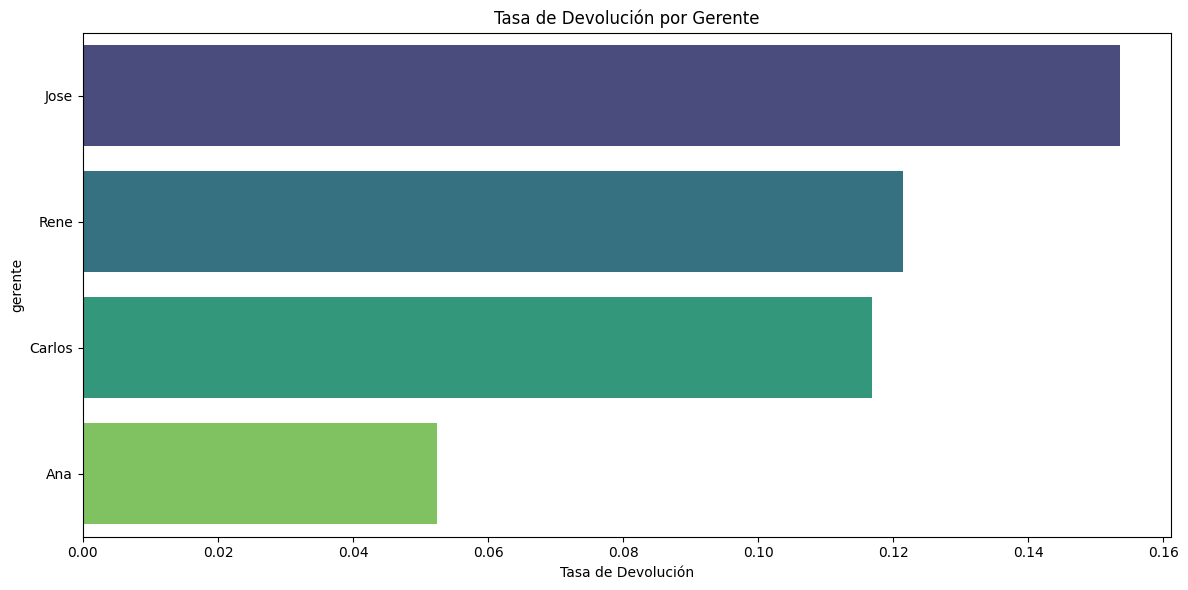

In [5]:
# Analisis grafico
manager_analysis = eda.analyze_by_manager(plot=True)

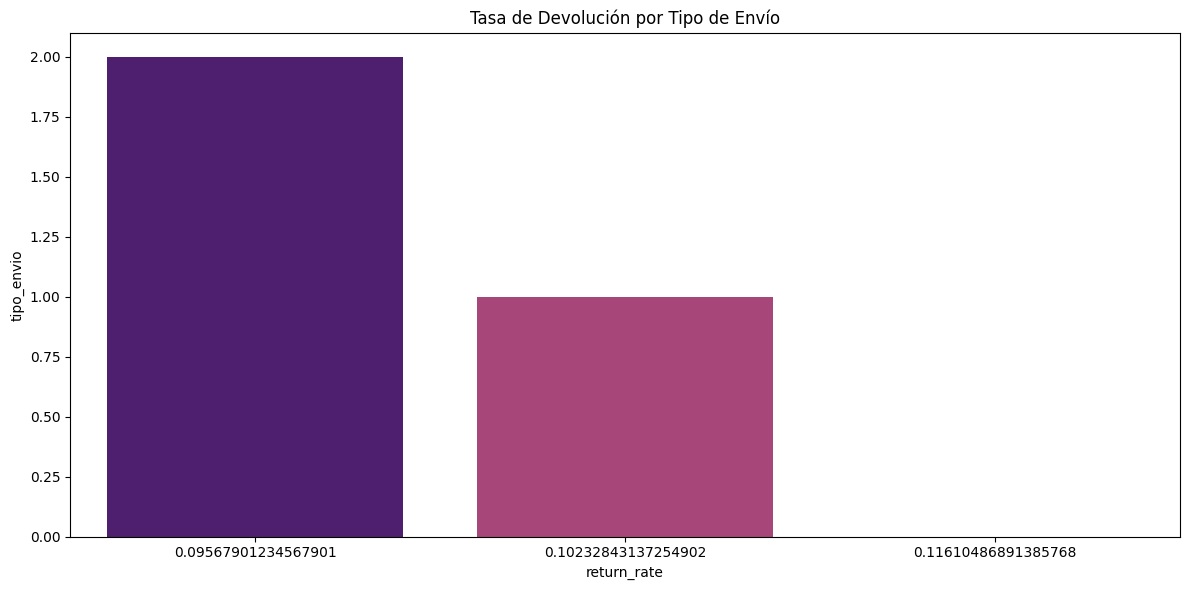

In [6]:
shipping_analysis = eda.analyze_by_shipping(plot=True)


### 2.2 Patrones Temporales


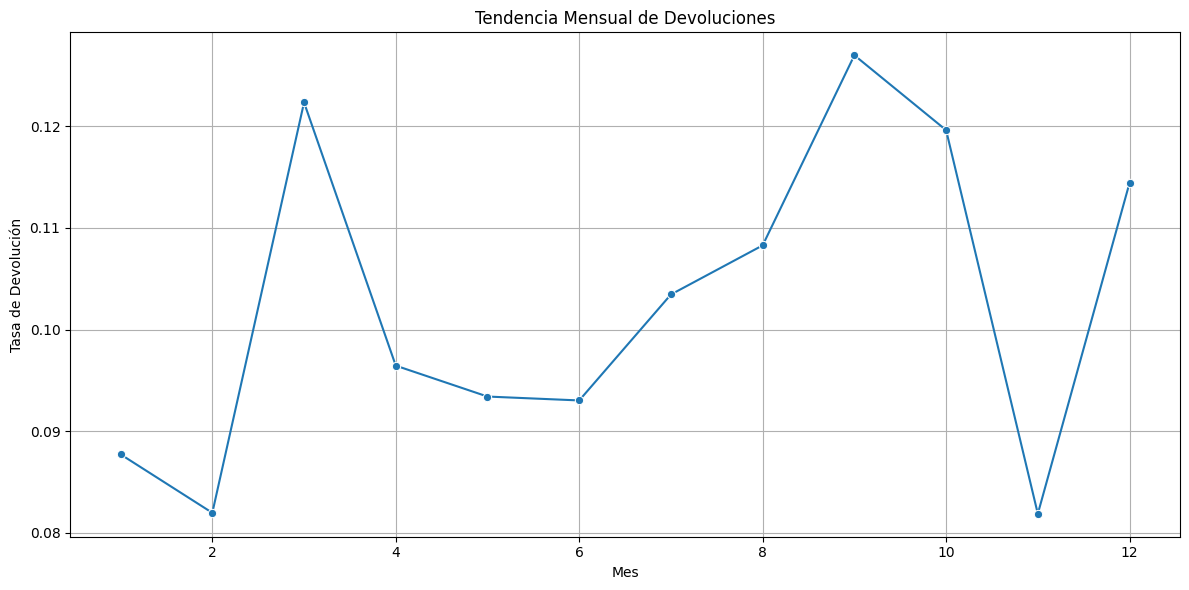

In [7]:
temporal_analysis = eda.analyze_temporal_patterns(plot=True)


---
## 3. Modelado Predictivo y Segmentacion



### 3.1 Clasificacion (Prediccion de Devoluciones)


In [8]:
# Entrenar clasificador
classifier = ReturnClassifier(n_estimators=100, random_state=42)
metrics = classifier.fit(df, validation_split=0.2)

print("Metricas del Clasificador:")
print(metrics)

# Importancia de variables
print("\nImportancia de Variables:")
print(classifier.feature_importance())

Metricas del Clasificador:
{'train_accuracy': 0.9673790776152981, 'val_accuracy': 0.849438202247191, 'train_f1': 0.8209876543209876, 'val_f1': 0.0}

Importancia de Variables:
      feature  importance
0    cantidad    0.606100
3         mes    0.176782
1   prioridad    0.101027
2  tipo_envio    0.072817
4   trimestre    0.043274


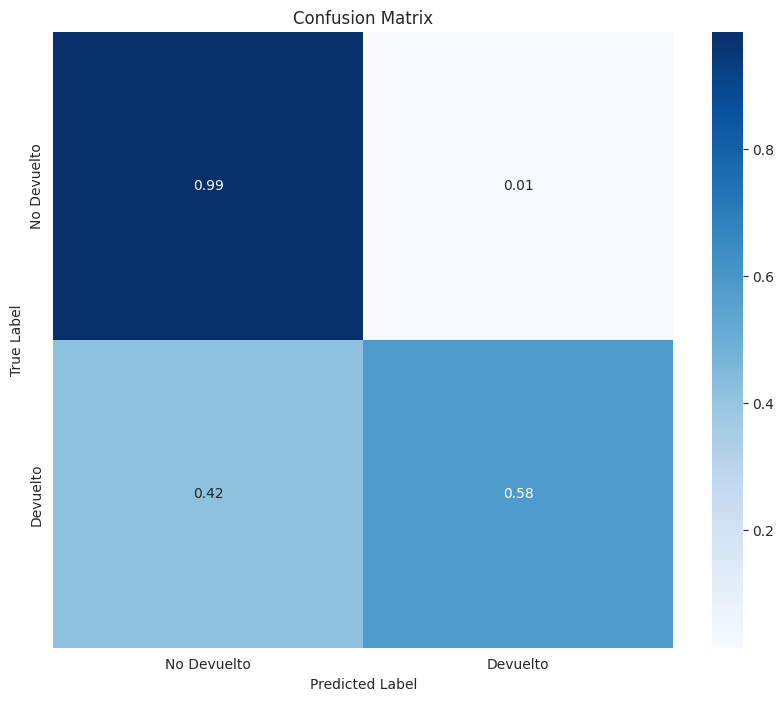

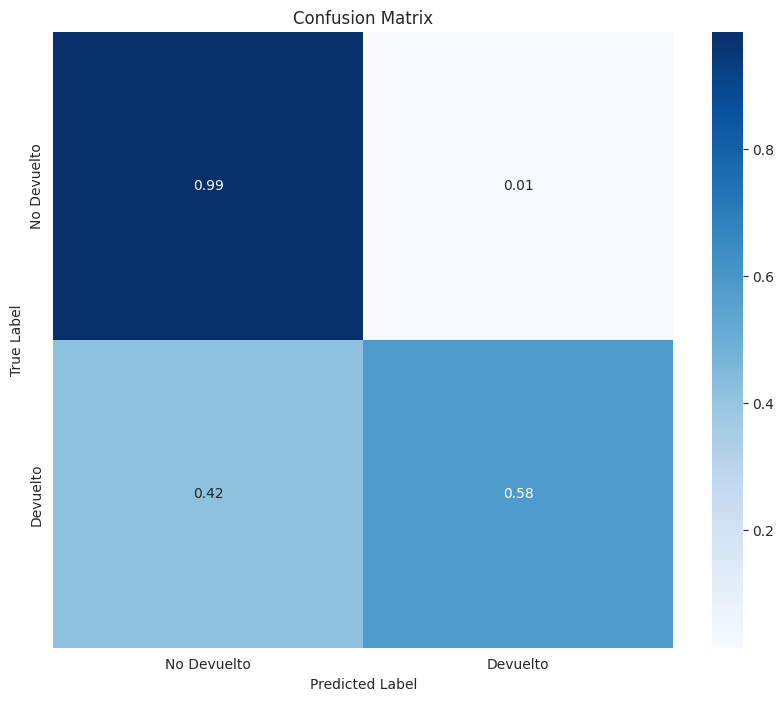

In [9]:
# Evaluacion visual
evaluator = ModelEvaluator()
X, y = classifier.prepare_features(df)
y_pred = classifier.predict(df)

evaluator.plot_confusion_matrix(y, y_pred, normalize=True)

# Curva ROC
y_proba = classifier.predict_proba(df)[:, 1]
evaluator.plot_roc_curve(y, y_proba)


### 3.2 Clustering (Segmentacion de Clientes)


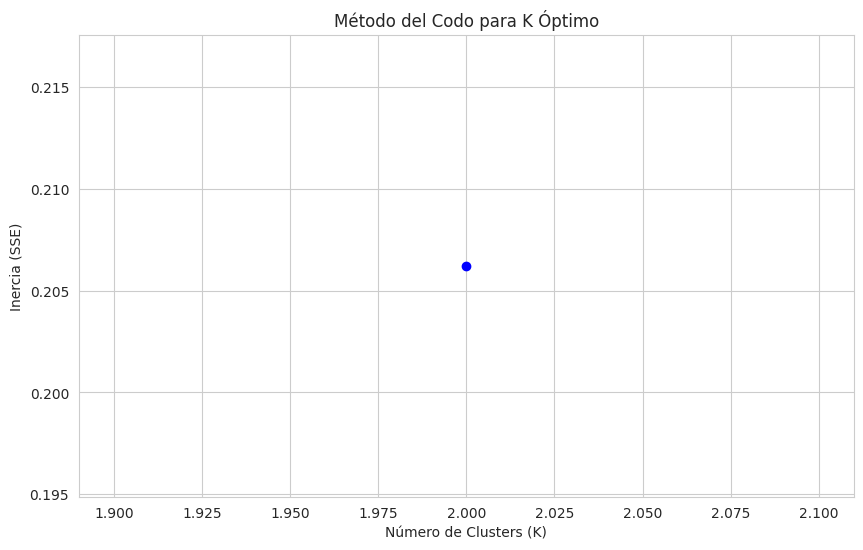

In [10]:
# Preparar datos de clientes
segmentation = CustomerSegmentation()
df_customers = segmentation.prepare_customer_features(df)

# Encontrar K optimo
elbow = segmentation.find_optimal_k(df_customers, plot=True)

In [11]:
# Segmentar con K optimo
k_opt = elbow["optimal_k"]
print(f"Usando K optimo: {k_opt}")

segmentation = CustomerSegmentation(n_clusters=k_opt)
df_customers["cluster"] = segmentation.fit_predict(df_customers)

# Analisis de perfiles
profiles = segmentation.get_cluster_profiles(df_customers)
print("Perfiles de Segmentos:")
profiles

Usando K optimo: 2
Perfiles de Segmentos:


,cluster,n_customers,avg_cantidad,avg_frecuencia,avg_tasa_devolucion,segment_name
0,0,1,31143.0,1233.0,0.111922,Premium
1,1,2,12290.0,495.0,0.091691,Estándar


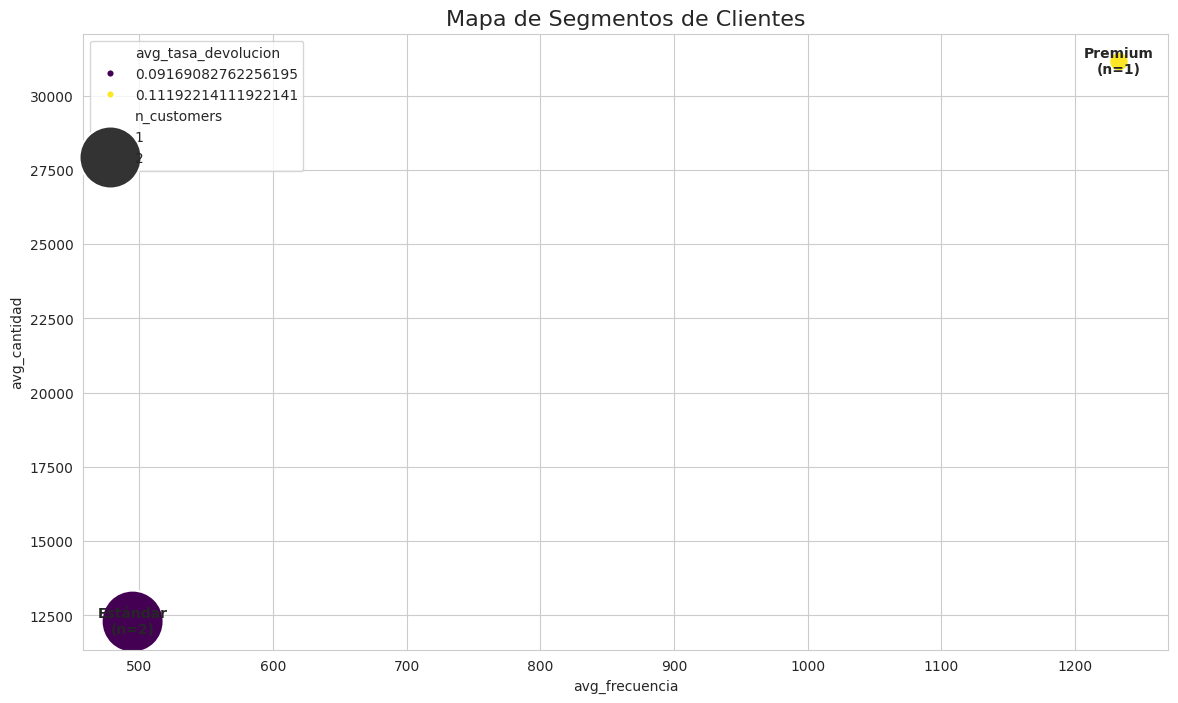

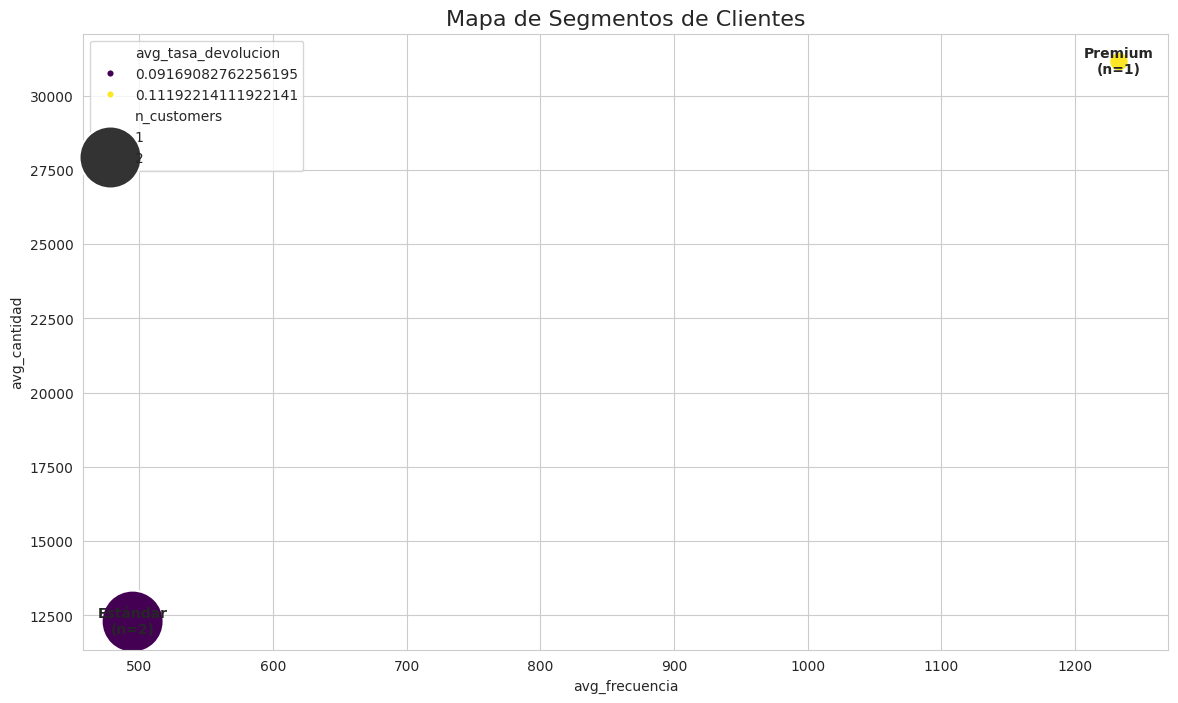

In [12]:
# Visualizar segmentos
visualizer = ExecutiveVisualizer()
visualizer.plot_customer_segments(profiles)


---
## 4. Conclusiones y Estrategia


In [13]:
# Generar estrategia
strategy = BusinessStrategy()
strategy.analyze_all_insights(
    manager_analysis=manager_analysis,
    shipping_analysis=shipping_analysis,
    temporal_analysis=temporal_analysis,
    cluster_profiles=profiles,
)

# Reporte final
report = strategy.generate_strategy_report()

print("=== RECOMENDACIONES ESTRATEGICAS ===")
for rec in report["recommendations"]:
    print(f"\n[{rec.priority}] {rec.title}")
    print(f"Accion: {rec.description}")
    print(f"Impacto Esperado: {rec.impact}")

=== RECOMENDACIONES ESTRATEGICAS ===

[Alta] Programa de Capacitación Focalizada
Accion: Implementar capacitación para gerentes con tasas de devolución superiores al promedio: Carlos, Jose, Rene.
Impacto Esperado: Alto (Reducción 5-10% devoluciones)

[Media] Auditoría de Proveedor de 0.0
Accion: El método 0.0 tiene la mayor tasa de devolución (11.6%). Realizar auditoría de calidad.
Impacto Esperado: Medio

[Baja] Ajuste de Stock Estacional
Accion: Alinear inventario con picos de devolución identificados en el análisis temporal.
Impacto Esperado: Bajo

[Media] Programa VIP para Segmento Premium
Accion: Crear incentivos de retención para el segmento de alto valor y baja devolución.
Impacto Esperado: Alto (Retención)


In [14]:
# Propuesta de Arquitectura
print("=== ARQUITECTURA PROPUESTA ===")
for k, v in report["architecture"].items():
    print(f"{k.upper()}:\n {v}\n")

=== ARQUITECTURA PROPUESTA ===
COMPONENTS:
 ['Ingesta: Apache Kafka', 'Procesamiento: Apache Spark Streaming', 'Almacenamiento: Delta Lake', 'ML Ops: MLflow', 'Visualización: Apache Superset']

DATA_FLOW:
 Transacciones -> Kafka -> Spark (Enriquecimiento + ML Predicción) -> Delta Lake -> Superset

IMPLEMENTATION_PHASES:
 ['Fase 1: Piloto de Ingesta (Kafka)', 'Fase 2: Procesamiento Batch (Spark)', 'Fase 3: Real-time Scoring', 'Fase 4: Dashboarding Automatizado']

ESTIMATED_BENEFITS:
 ['Detección de fraude en tiempo real', 'Predicción dinámica de inventario', 'Escalabilidad a millones de transacciones']

